# Libraries and Setup

In [101]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cuda


In [102]:
import torch
from einops import rearrange
import torch.nn as nn
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


def create_coordinate_map(img):
    num_channels, height, width = img.shape

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y


def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1 / (2 * sigma ** 2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


def train(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()


def plot_reconstructed_and_original_image(original_img, reconstructed_img, title):
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(reconstructed_img)
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img)
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()


def plot_super_resolution_and_low_resolution_image(low_resolution_image, super_resolution_img, title):
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(super_resolution_img)
    ax0.set_title("Super Resolution Image: 400x400")

    ax1.imshow(low_resolution_image)
    ax1.set_title("Low Resolution Image: 200x200")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [103]:
# Download the dog image if it doesn't exist
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

img = torchvision.io.read_image("dog.jpg")

dog.jpg exists


In [104]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))

In [105]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled).to(device)
print(img_scaled.shape)
img_scaled

torch.Size([3, 1365, 2048])


tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [106]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

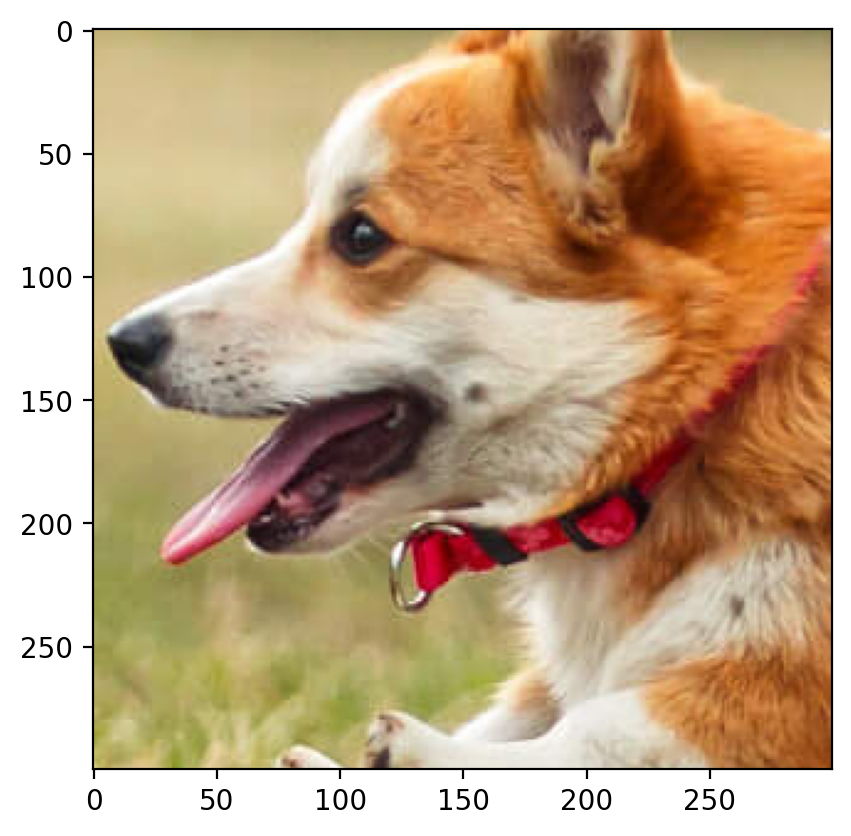

In [107]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [108]:
crop = crop.to(device)

In [109]:
dog_X, dog_Y = create_coordinate_map(crop)
dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [110]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

dog_X_scaled = dog_X_scaled.float()

In [111]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [112]:
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

(3925934080, 8216903680)

In [113]:
X_rff = create_rff_features(dog_X_scaled, 1000, 0.008)

In [114]:
torch.cuda.mem_get_info()

(3925934080, 8216903680)

In [115]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 1000)

Epoch 0 loss: 0.388069
Epoch 100 loss: 0.076728
Epoch 200 loss: 0.037360
Epoch 300 loss: 0.034641
Epoch 400 loss: 0.034277
Epoch 500 loss: 0.034129
Epoch 600 loss: 0.034065
Epoch 700 loss: 0.034038
Epoch 800 loss: 0.034028
Epoch 900 loss: 0.034024


0.03402310982346535

torch.Size([300, 300, 3])
torch.Size([300, 300, 3])
<class 'torch.Tensor'> <class 'torch.Tensor'>


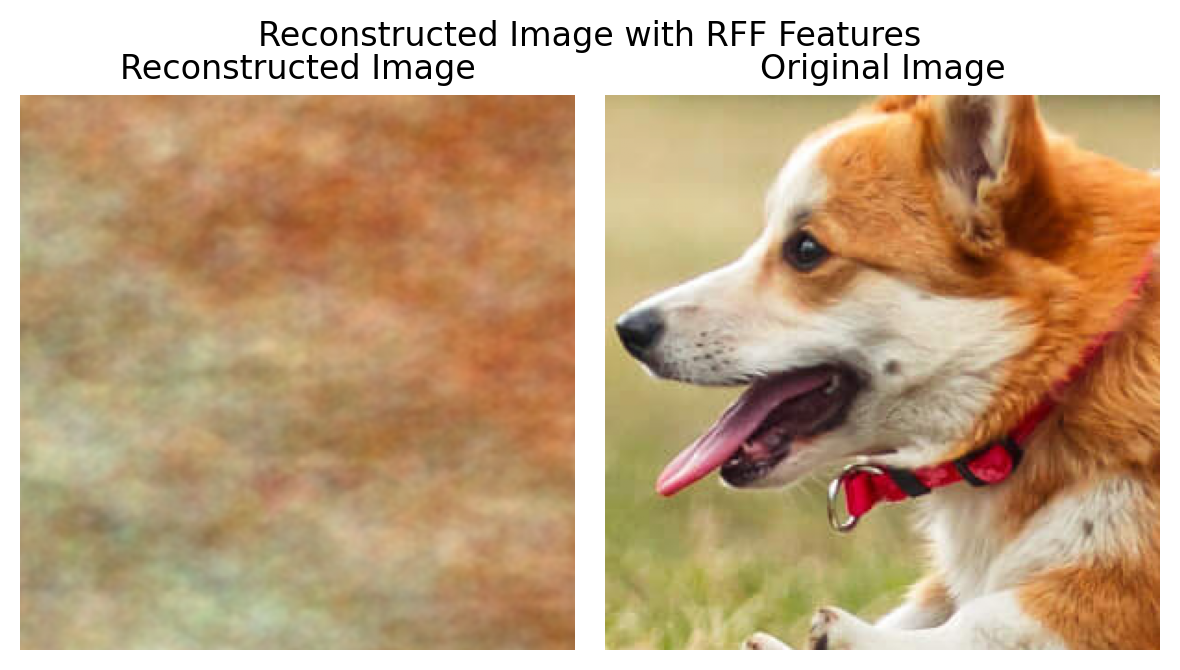

In [116]:
num_channels, height, width = crop.shape
net.eval()

with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(height, width, num_channels)

print(crop.cpu().permute(1, 2, 0).shape)
print(outputs.cpu().shape)

print(type(crop.cpu().permute(1, 2, 0)), type(outputs.cpu()))

plot_reconstructed_and_original_image(crop.cpu().permute(1, 2, 0), outputs.cpu(), title="Reconstructed Image with RFF Features")

In [117]:
def calculate_rmse(original_image, reconstructed_image):
    return np.sqrt(np.mean((original_image - reconstructed_image) ** 2))


def calculate_psnr(original_image, reconstructed_image):
    return 20 * np.log10(1.0 / calculate_rmse(original_image, reconstructed_image))

In [118]:
num_channels, height, width = crop.shape
outputs_permuted = outputs.permute(2, 0, 1)

print(f"RMSE: {calculate_rmse(crop.cpu().detach().numpy(), outputs_permuted.cpu().detach().numpy())}")
print(f"PSNR: {calculate_psnr(crop.cpu().detach().numpy(), outputs_permuted.cpu().detach().numpy())}")

RMSE: 0.18445352850763436
PSNR: 14.68226065024665
